In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Looking at the data


In [2]:
# dispaly max rows 50
pd.set_option('display.max_rows', 50)

In [3]:
survey1_raw = pd.read_csv('data/salary_survey-1.csv')
survey2_raw = pd.read_csv('data/salary_survey-2.csv')
survey3_raw = pd.read_csv('data/salary_survey-3.csv')

## Pre processing

### get salary in usd

In [4]:
survey1_raw['What is your annual salary?'].value_counts()

80000                                      448
75000                                      441
90000                                      424
60000                                      398
65000                                      390
                                          ... 
61380                                        1
37701                                        1
8,500,000 + bonus (this year 3 million)      1
67619.5                                      1
35                                           1
Name: What is your annual salary?, Length: 5350, dtype: int64

In [5]:
currency_conversion = pd.read_csv('data/currency_conversion_rates.csv')


In [6]:
import pandas as pd
import re

def clean_salary_data(salary_column):
    # Remove commas from the salary column
    salary_column = salary_column.str.replace(',', '')
    salary_column = salary_column.str.replace(' ', '') 
    # Remove currency symbols from the salary column using regex
    currency_regex = re.compile(r'[£$€¥₹₩]')
    salary_column = salary_column.str.replace(currency_regex, '')
    
    # Extend the shorthand in the salary column
    salary_column = salary_column.str.replace('k', '000')
    salary_column = salary_column.str.replace('m', '000000')
    
    #remove any non numeric characters
    salary_column = salary_column.str.extract('(\d+)', expand=False)
    
    # Convert the salary column to numeric values
    salary_column = pd.to_numeric(salary_column)
    
    return salary_column

def convert_salaries(row, currency_conversion):
    currency = row['Please indicate the currency']
    salary = row['What is your annual salary?']

    # If currency is NaN, return None (which will be translated to NaN in a DataFrame)
    if pd.isnull(currency) or pd.isnull(salary):
        return None
    
    if currency == 'USD':
        return salary
    else:
        exchange_rate = currency_conversion.loc[currency_conversion['Currency'] == currency, 'Rate to USD']
        if not exchange_rate.empty:
            # Convert the Series to a single value
            exchange_rate = exchange_rate.iloc[0]
            # Correct the exchange rate application
            return salary / exchange_rate
        else:
            return None



# Clean and preprocess the salary column
survey1_raw['What is your annual salary?'] = clean_salary_data(survey1_raw['What is your annual salary?'])

# Convert salaries to USD
survey1_raw['salary_usd'] = survey1_raw.apply(lambda row: convert_salaries(row, currency_conversion), axis=1)



In [7]:
survey3_raw['salary_cleaned'] = clean_salary_data(survey3_raw['Annual Base Pay'])


In [8]:
survey1_raw['How many years of post-college professional work experience do you have?'].value_counts()

11 - 20 years       9449
5-7 years           6378
8 - 10 years        5958
2 - 4 years         5442
21 - 30 years       3947
1 year or less      1739
31 - 40 years       1252
41 years or more     209
Name: How many years of post-college professional work experience do you have?, dtype: int64

In [9]:
survey2_raw['Years Experience in Industry'].value_counts()

5-10     1366
2-5      1166
10-20    1111
0-2       540
20+       221
Name: Years Experience in Industry, dtype: int64

## Get common set off columns

In [10]:
survey1_sub = pd.DataFrame({
    'Timestamp' : survey1_raw['Timestamp'],
    'Role' : survey1_raw['Job title'],
    'Location' : survey1_raw['Where are you located? (City/state/country)'],
    'Salary' : survey1_raw['salary_usd'],
    'Years_experience' : survey1_raw['How many years of post-college professional work experience do you have?'],
    'Bonus' : None
 })

In [11]:
survey2_sub = pd.DataFrame({
    'Timestamp' : survey2_raw['Timestamp'],
    'Role' : survey2_raw['Job Title In Company'],
    'Location': survey2_raw['Primary Location (City)'] + ', ' + survey2_raw['Primary Location (Country)'],
    'Salary' : survey2_raw['Total Base Salary in 2018 (in USD)'],
    'Years_experience' : survey2_raw['Years Experience in Industry'],
    'Bonus' : survey2_raw['Total Bonus in 2018 (cumulative annual value in USD)']
})

In [12]:
survey3_sub = pd.DataFrame({
    'Timestamp' : survey3_raw['Timestamp'],
    'Role' : survey3_raw['Job Title'],
    'Location' : survey3_raw['Location'],
    'Salary' : survey3_raw['salary_cleaned'],
    'Years_experience' : survey3_raw['Years of Experience'],
    'Bonus' : survey3_raw['Annual Bonus']
})

# Format years of experience

In [13]:
import re

def format_years_experience_ranges(years_experience):
    if pd.isna(years_experience):
        return years_experience

    if isinstance(years_experience, str) and years_experience.lower() in ['nan', 'none']:
        return None

    if isinstance(years_experience, str):
        # Check if the string contains any non-numeric or non-hyphen characters
        if re.search(r'[^0-9-]', years_experience):
            # Extract numbers from the string
            years_experience = re.sub(r'[^0-9-]', '', years_experience)

    if isinstance(years_experience, str) and '-' in years_experience:
        return None

    try:
        years = float(years_experience)
        if years <= 2:
            return '0-2'
        elif years <= 5:
            return '2-5'
        elif years <= 10:
            return '5-10'
        elif years <= 20:
            return '10-20'
        else:
            return '20+'
    except (ValueError, TypeError):
        return years_experience


# Apply the function to the 'Years_experience' column
survey3_sub['Years_experience'] = survey3_sub['Years_experience'].apply(format_years_experience_ranges)


In [14]:
survey1_sub.Years_experience.value_counts() 

11 - 20 years       9449
5-7 years           6378
8 - 10 years        5958
2 - 4 years         5442
21 - 30 years       3947
1 year or less      1739
31 - 40 years       1252
41 years or more     209
Name: Years_experience, dtype: int64

In [15]:
# Create a mapping dictionary
mapping = {
    '1 year or less': '0-2',
    '2 - 4 years': '2-5',
    '5-7 years': '5-10',
    '8 - 10 years': '5-10',
    '11 - 20 years': '10-20',
    '21 - 30 years': '20+',
    '31 - 40 years': '20+',
    '41 years or more': '20+'
}

# Apply the mapping to the 'Years_experience' column in survey1_sub
survey1_sub['Years_experience'] = survey1_sub['Years_experience'].map(mapping)

In [16]:
survey1_sub

,Timestamp,Role,Location,Salary,Years_experience,Bonus
0,4/24/2019 11:43:21,Talent Management Asst. Director,"Nashville, TN",75000.000000,10-20,None
1,4/24/2019 11:43:26,Operations Director,"Madison, Wi",65000.000000,5-10,None
2,4/24/2019 11:43:27,Market Research Assistant,"Las Vegas, NV",36330.000000,2-5,None
3,4/24/2019 11:43:27,Senior Scientist,"Cardiff, UK",44013.580607,5-10,None
4,4/24/2019 11:43:29,Social worker (embedded in primary care),"Southeast Michigan, USA",55000.000000,5-10,None
...,...,...,...,...,...,...
34369,12/23/2020 8:47:19,Pharmacist,"Philadelphia, PA",163000.000000,10-20,None
34370,12/23/2020 12:21:14,Support tech,"Sulpur Springs Texas, USA,",35.000000,2-5,None
34371,12/25/2020 10:52:24,Director,Singapore,221076.717306,20+,None
34372,12/26/2020 20:07:18,Analist,Santa Catarina,NaN,10-20,None


In [17]:
survey2_sub.Years_experience.value_counts()

5-10     1366
2-5      1166
10-20    1111
0-2       540
20+       221
Name: Years_experience, dtype: int64

In [18]:
survey3_sub.Years_experience.value_counts()

5-10     1046
2-5      1037
0-2       611
10-20     592
20+       145
Name: Years_experience, dtype: int64

In [19]:
survey3_sub

,Timestamp,Role,Location,Salary,Years_experience,Bonus
0,NaN,NaN,NaN,NaN,NaN,NaN
1,3/21/2016 12:54:49,Software Developer,"Raleigh, NC",122000.0,10-20,NaN
2,3/21/2016 12:58:52,Systems Engineer,"San Francisco, CA",125000.0,10-20,0
3,3/21/2016 12:58:57,Systems engineer,San Diego CA,83000.0,0-2,$50.00
4,3/21/2016 12:58:58,Senior Developer,"Bentonville, AR",65000.0,10-20,"5,000"
...,...,...,...,...,...,...
3773,6/3/2020 7:52:21,Product Manager,"Berlin, Germany",85000.0,5-10,0
3774,8/6/2020 22:20:35,Sr. Software Engineer,Denver,134000.0,10-20,12000
3775,8/20/2020 18:07:03,Software Engineer,"Seattle, WA",96750.0,0-2,6288
3776,10/17/2020 7:43:25,Senior Consultant (Senior Software Engineer),Cleveland,120000.0,5-10,5000


In [20]:
# Join all dataframes to one
all_surveys = pd.concat([survey1_sub, survey2_sub, survey3_sub])


In [21]:
all_surveys.Bonus = clean_salary_data(all_surveys.Bonus)

In [22]:
all_surveys.Years_experience.value_counts() 

5-10     14748
10-20    11152
2-5       7645
20+       5774
0-2       2890
Name: Years_experience, dtype: int64

# Data prep 

In [23]:
from geotext import GeoText

all_surveys = all_surveys.dropna(subset=['Salary', 'Role'])

all_surveys['Salary'] = all_surveys['Salary'].astype(int)

# Remove rows with NaN values in essential columns

# 3. Technical Role Identification
technical_keywords = [
    'engineer', 'architect', 'developer', 'programmer', 'analyst', 
    'technician', 'specialist', 'administrator', 'scientist', 'researcher', 
    'designer', 'consultant', 'manager', 'director', 'CTO', 'CIO', 
    'devops', 'security', 'cloud', 'UI', 'UX', 'web', 'mobile', 'game', 
    'embedded', 'data', 'AI', 'ML', 'ETL', 'QA', 'IT', 'technical', 
    'tech', 'software', 'hardware', 'network', 'systems', 'database', 
    'product', 'blockchain'
]

all_surveys['Role'] = all_surveys['Role'].str.lower()
all_surveys['is_technical'] = all_surveys['Role'].str.lower().str.contains('|'.join(technical_keywords), na=False)

#datetime 
all_surveys['Timestamp'] = pd.to_datetime(all_surveys['Timestamp'])


# extract coutnry and city using NER 
all_surveys['Country'] = all_surveys['Location'].apply(lambda x: list(GeoText(x).country_mentions.keys())[0] if isinstance(x, str) and GeoText(x).country_mentions else '')
all_surveys['City'] = all_surveys['Location'].apply(lambda x: GeoText(x).cities[0] if isinstance(x, str) and GeoText(x).cities else '')

# 4. Outlier Filtering Using IQR
def filter_outliers_using_iqr(df, column='Salary'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

technical_filtered = filter_outliers_using_iqr(all_surveys[all_surveys['is_technical']], 'Salary')
non_technical_filtered = filter_outliers_using_iqr(all_surveys[~all_surveys['is_technical']], 'Salary')

# filtering outliers using IQR

In [24]:
def filter_outliers_using_iqr(df, column='Salary'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

technical_filtered = filter_outliers_using_iqr(all_surveys[all_surveys['is_technical']], 'Salary')
non_technical_filtered = filter_outliers_using_iqr(all_surveys[~all_surveys['is_technical']], 'Salary')



# Compensation analysis by role

Average Compensation by Role Type:
is_technical
False    6.786408e+09
True     1.060299e+05
Name: Salary, dtype: float64


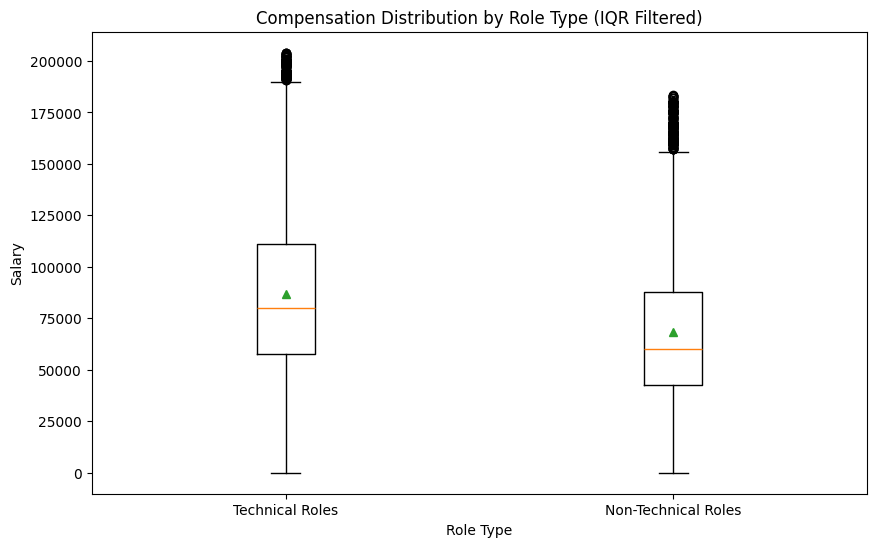


Summary statistics for technical roles:
count    2.675100e+04
mean     1.060299e+05
std      9.236970e+05
min      0.000000e+00
25%      5.895150e+04
50%      8.200000e+04
75%      1.170000e+05
max      1.200000e+08
Name: Salary, dtype: float64

Summary statistics for non-technical roles:
count    1.491900e+04
mean     6.786408e+09
std      8.187606e+11
min      0.000000e+00
25%      4.432200e+04
50%      6.400000e+04
75%      1.000000e+05
max      1.000000e+14
Name: Salary, dtype: float64


In [25]:
average_compensation = all_surveys.groupby('is_technical')['Salary'].mean()
print("Average Compensation by Role Type:")
print(average_compensation)

plt.figure(figsize=(10, 6))
plt.boxplot(
    [technical_filtered['Salary'], non_technical_filtered['Salary']], 
    positions=[0, 1], showmeans=True
)
plt.xticks([0, 1], ['Technical Roles', 'Non-Technical Roles'])
plt.title('Compensation Distribution by Role Type (IQR Filtered)')
plt.xlabel('Role Type')
plt.ylabel('Salary')
plt.show()
print("\nSummary statistics for technical roles:")
print(all_surveys[all_surveys['is_technical']]['Salary'].describe())

print("\nSummary statistics for non-technical roles:")
print(all_surveys[~all_surveys['is_technical']]['Salary'].describe())

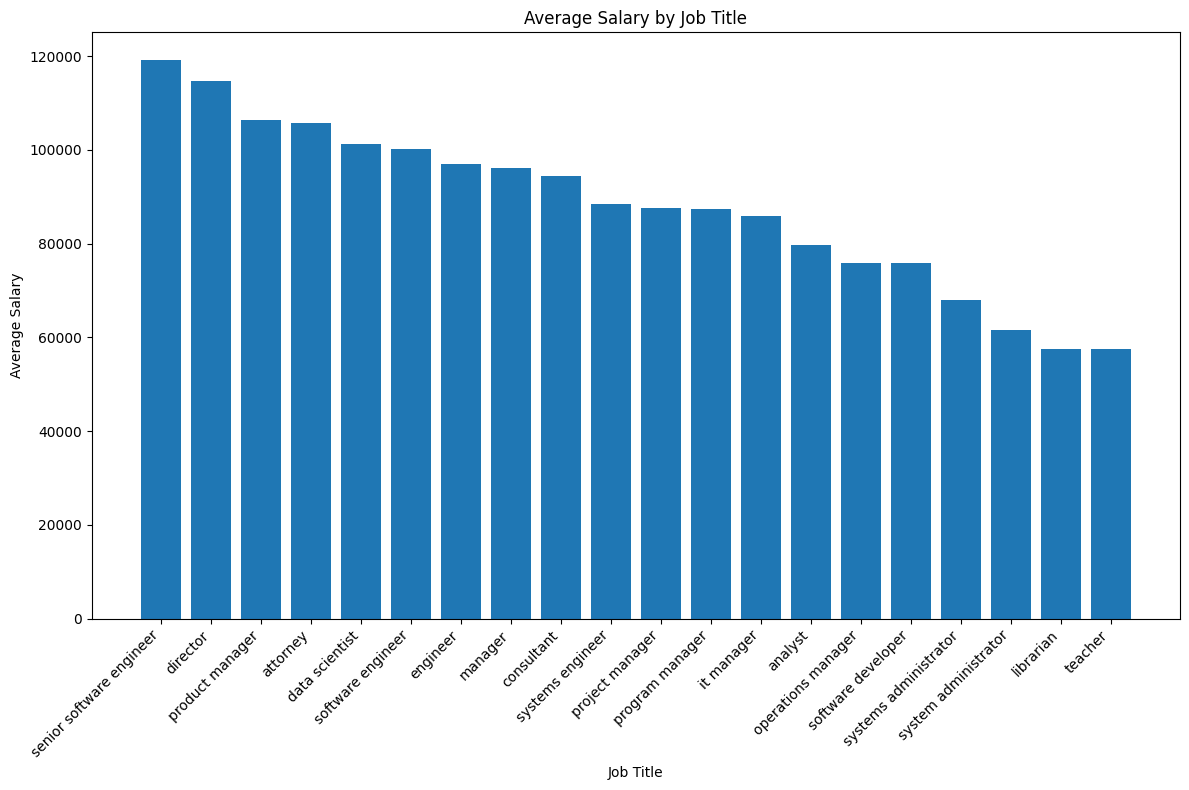

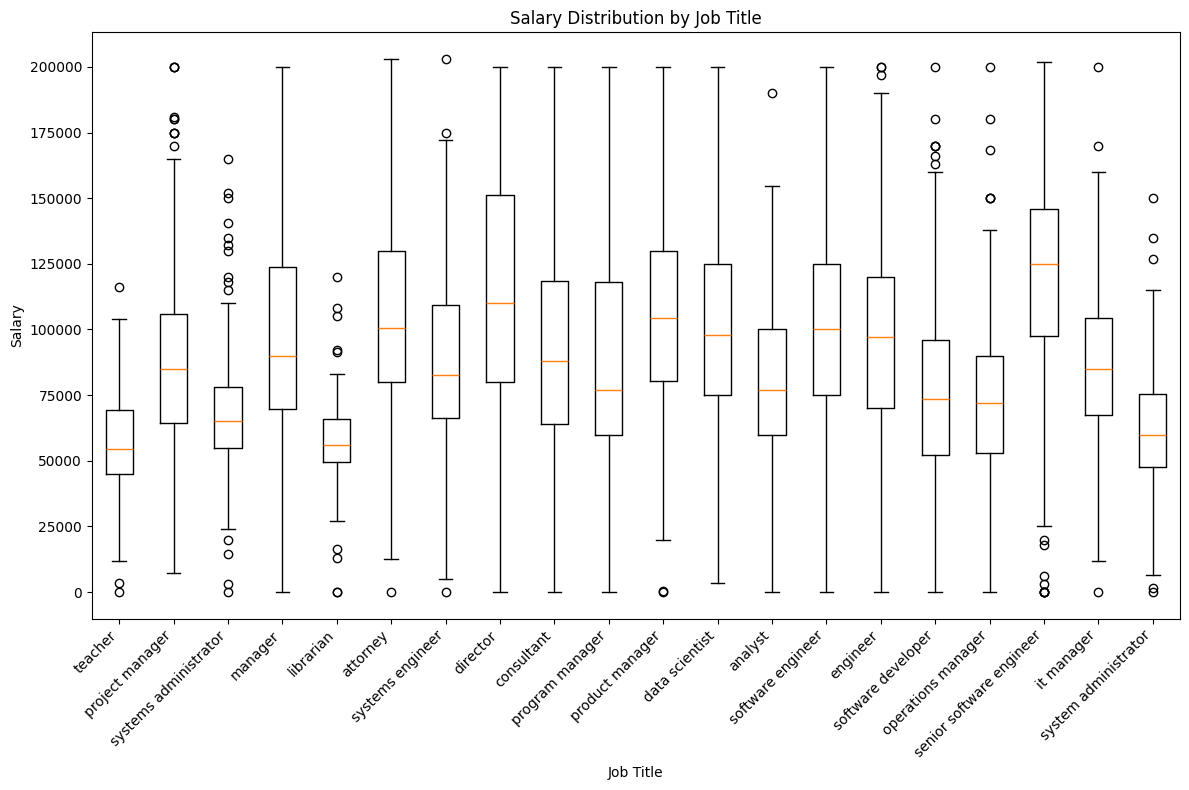

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


all_surveys_filtered_salary = filter_outliers_using_iqr(all_surveys, 'Salary')

# top 20 job titles by frequency
top_job_titles = all_surveys_filtered_salary['Role'].value_counts().head(20).index

# Filter the data to include only the top job titles
filtered_surveys = all_surveys_filtered_salary[all_surveys_filtered_salary['Role'].isin(top_job_titles)]

#  average salary for each job title
average_salaries = filtered_surveys.groupby('Role')['Salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(average_salaries.index, average_salaries.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Title')
plt.ylabel('Average Salary')
plt.title('Average Salary by Job Title')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
job_titles = filtered_surveys['Role'].unique()
salaries_by_title = [filtered_surveys[filtered_surveys['Role'] == title]['Salary'] for title in job_titles]
plt.boxplot(salaries_by_title, labels=job_titles)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Title')
plt.ylabel('Salary')
plt.title('Salary Distribution by Job Title')
plt.tight_layout()
plt.show()

# Compensation by geography

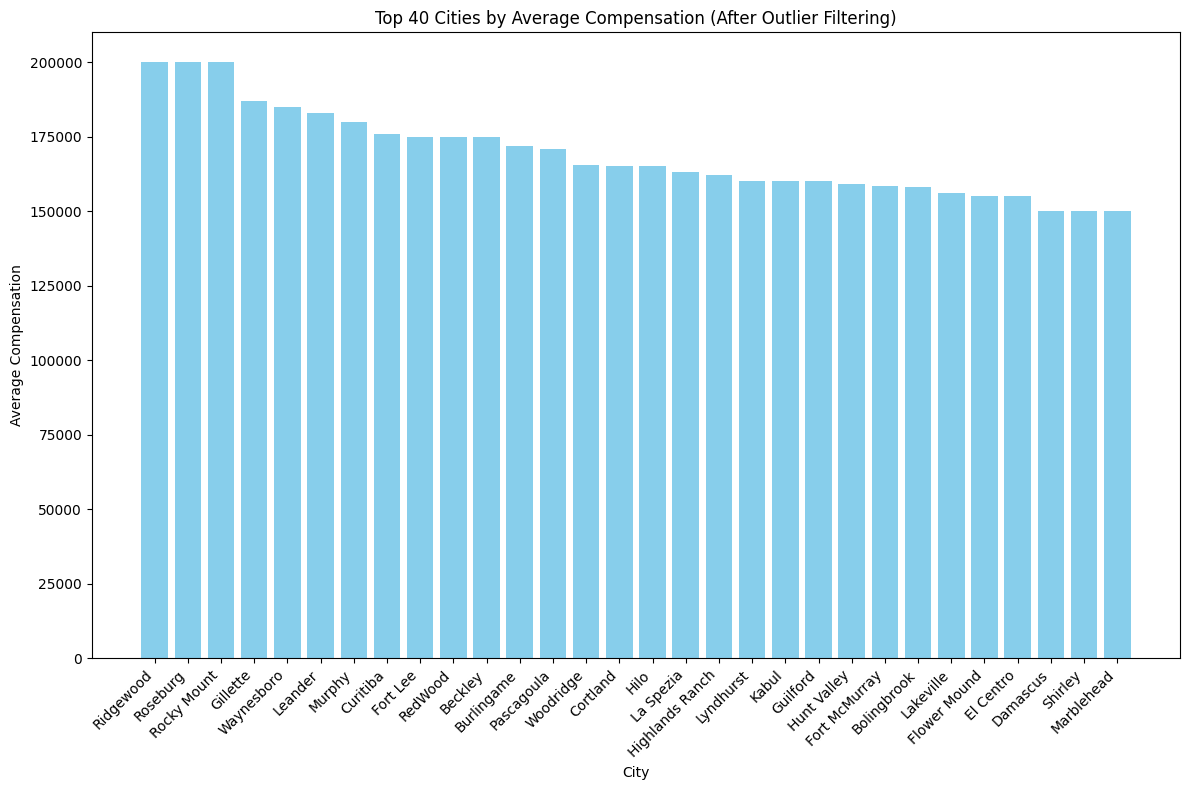

Compensation Statistics for Cities (After Outlier Filtering):
           City     mean    min    max
      Ridgewood 200000.0 200000 200000
       Roseburg 200000.0 200000 200000
    Rocky Mount 200000.0 200000 200000
       Gillette 187000.0 187000 187000
     Waynesboro 185000.0 185000 185000
        Leander 183000.0 183000 183000
         Murphy 180000.0 180000 180000
       Curitiba 176000.0 176000 176000
       Fort Lee 175000.0 175000 175000
        RedWood 175000.0 175000 175000
        Beckley 175000.0 175000 175000
     Burlingame 172000.0 166000 180000
     Pascagoula 171000.0 171000 171000
      Woodridge 165500.0 165500 165500
       Cortland 165000.0 165000 165000
           Hilo 165000.0 165000 165000
      La Spezia 163040.0 163040 163040
Highlands Ranch 162000.0 162000 162000
      Lyndhurst 160000.0 160000 160000
          Kabul 160000.0 120000 200000
       Guilford 160000.0 160000 160000
    Hunt Valley 159000.0 159000 159000
  Fort McMurray 158438.0 147384 169492
  

In [28]:
# Grouped the data by 'City' and apply the outlier filtering to each group
all_surveys_filtered_salary = filter_outliers_using_iqr(all_surveys, 'Salary')

all_surveys_filtered = all_surveys_filtered_salary.groupby('City').apply(lambda x: filter_outliers_using_iqr(x)).reset_index(drop=True)

# Calculate the average, minimum, and maximum compensation per city on this filtered dataset
city_stats_filtered = all_surveys_filtered.groupby('City')['Salary'].agg(['mean', 'min', 'max']).reset_index()

# Sort the filtered cities by average compensation in descending order
city_stats_filtered_sorted = city_stats_filtered.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(city_stats_filtered_sorted.head(30)['City'], city_stats_filtered_sorted.head(30)['mean'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('City')
plt.ylabel('Average Compensation')
plt.title('Top 40 Cities by Average Compensation (After Outlier Filtering)')
plt.tight_layout()
plt.show()

print("Compensation Statistics for Cities (After Outlier Filtering):")
print(city_stats_filtered_sorted.head(40).to_string(index=False))


In [29]:
# karistad is a city in sweden 

# Bonus Analysis

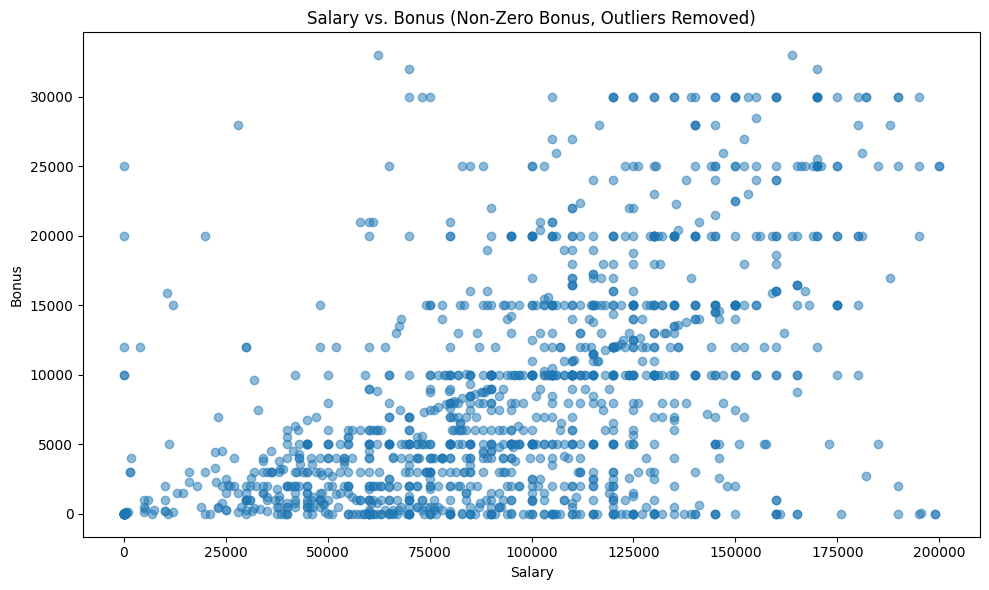

Correlation coefficient between salary and bonus (filtered data): 0.54


In [30]:
all_surveys_filtered_salary = filter_outliers_using_iqr(all_surveys, 'Salary')

all_surveys_bonus = all_surveys_filtered_salary[(all_surveys_filtered_salary['Bonus'].notna()) & (all_surveys_filtered_salary['Bonus'] != 0)]

all_surveys_bonus_filtered = filter_outliers_using_iqr(all_surveys_bonus, 'Bonus')

#  scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(all_surveys_bonus_filtered['Salary'], all_surveys_bonus_filtered['Bonus'], alpha=0.5)
plt.title('Salary vs. Bonus (Non-Zero Bonus, Outliers Removed)')
plt.xlabel('Salary')
plt.ylabel('Bonus')
plt.tight_layout()
plt.show()

# Calculate and print the correlation coefficient between salary and bonus for the filtered data
correlation_bonus_filtered = all_surveys_bonus_filtered['Salary'].corr(all_surveys_bonus_filtered['Bonus'])
print(f"Correlation coefficient between salary and bonus (filtered data): {correlation_bonus_filtered:.2f}")


# Experience and Total Compensation Analysis

/var/folders/2l/c6d86x7x7175_t80tw8b_s6r0000gn/T/ipykernel_39558/2203043099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_surveys_exp_filtered['Years_experience'] = pd.Categorical(


<Figure size 1200x800 with 0 Axes>

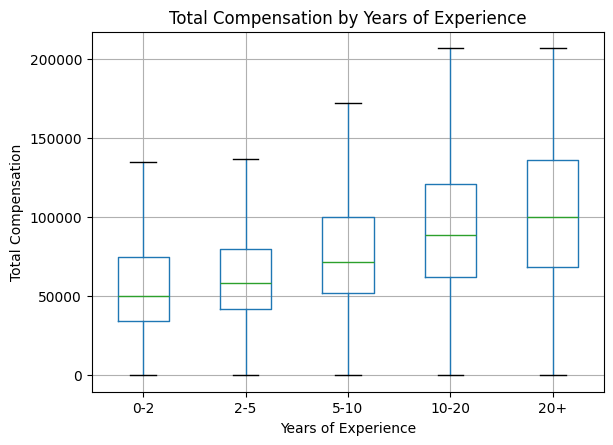

In [31]:

# Calculate Total Compensation by adding Salary and Bonus, filling missing bonus values with 0
all_surveys['TotalCompensation'] = all_surveys['Salary'] + all_surveys['Bonus'].fillna(0)


# Filter the DataFrame to exclude any rows without 'Years_experience' data
all_surveys_exp = all_surveys.dropna(subset=['Years_experience'])

all_surveys_exp_filtered = filter_outliers_using_iqr(all_surveys_exp, 'TotalCompensation')

# Convert 'Years_experience' into a categorical variable i
all_surveys_exp_filtered['Years_experience'] = pd.Categorical(
    all_surveys_exp_filtered['Years_experience'],
    categories=['0-2', '2-5', '5-10', '10-20', '20+'],
    ordered=True
)

# plot
plt.figure(figsize=(12, 8))
all_surveys_exp_filtered.boxplot(
    column='TotalCompensation', 
    by='Years_experience', 
    showfliers=False  
)
plt.title('Total Compensation by Years of Experience')
plt.suptitle('')  
plt.xlabel('Years of Experience')
plt.ylabel('Total Compensation')
plt.show()


#  Change in componesation for technical vs non technical persons year over year

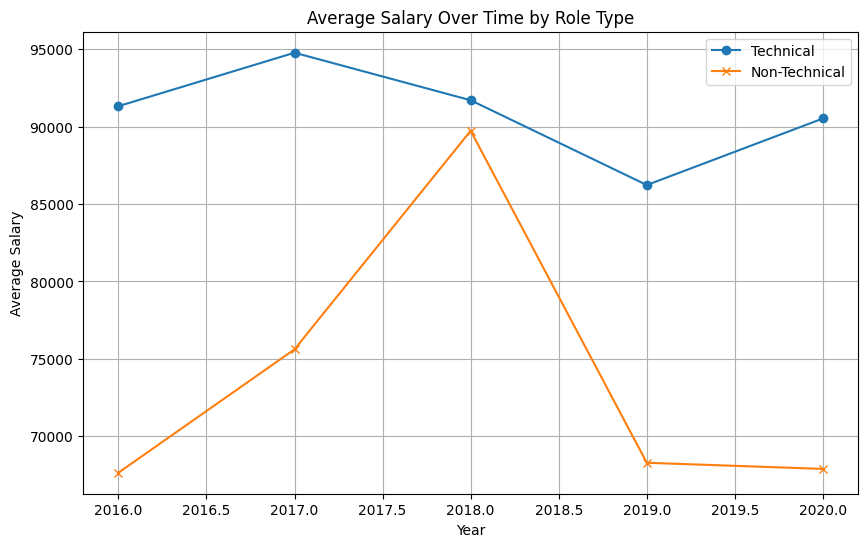

In [32]:
# Assuming the 'Timestamp' column has been converted to datetime and 'is_technical' has been defined
# Separate the data into technical and non-technical groups
technical = all_surveys[all_surveys['is_technical'] == True]
non_technical = all_surveys[all_surveys['is_technical'] == False]

# Filter outliers for both groups using the IQR method, if not already done
technical_filtered = filter_outliers_using_iqr(technical, 'Salary')
non_technical_filtered = filter_outliers_using_iqr(non_technical, 'Salary')

# Group by year and calculate the average salary for both technical and non-technical roles
technical_salary_by_year = technical_filtered.groupby(technical_filtered['Timestamp'].dt.year)['Salary'].mean()
non_technical_salary_by_year = non_technical_filtered.groupby(non_technical_filtered['Timestamp'].dt.year)['Salary'].mean()

# Visualize the average salary over time by role type
plt.figure(figsize=(10, 6))
plt.plot(technical_salary_by_year.index, technical_salary_by_year.values, label='Technical', marker='o')
plt.plot(non_technical_salary_by_year.index, non_technical_salary_by_year.values, label='Non-Technical', marker='x')
plt.title('Average Salary Over Time by Role Type')
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.legend()
plt.grid(True)
plt.show()
